# 2.3 선형 회귀 모델

### 여러 변수로부터 하나 또는 여러 개의 값을 예측하는 기법

y = a*x + b + e 이런 식일 때 x로부터 y를 예측하는 것이 목표 

## 2.3.2 파이토치로 선형 회귀 모델 만들기(직접 만들기)


In [17]:
import torch

# 창의 계수
w_true = torch.Tensor([1,2,3])

# X 데이터 준비, 절편을 회귀 계수에 포함시키기 위해
# X의 최초 차원에 1을 추가해 둔다.

x = torch.cat([torch.ones(100,1), torch.randn(100,2)], 1)

In [18]:
# 참의 계수와 각 x의 내적을 행렬과 벡터의 곱으로 모아서 계산
y = torch.mv(x, w_true) + torch.randn(100) * 0.5

In [19]:
# 기울기 하강으로 최적화하기 위해 파라미터 Tensor를 난수로 초기화해서 생성
w = torch.randn(3, requires_grad = True)
# 학습률
gamma = 0.1

In [20]:
losses = []

for epoc in range(100):
    #전회의 backward 메소드로 계산된 경사값을 초기화
    w.grad = None
    y_pred = torch.mv(x,w)
    
    # MSE loss와 w에 의한 미분을 계산
    loss = torch.mean((y-y_pred)**2)
    loss.backward()
    
    # 경사를 갱신한다 
    # w를 그대로 대입해서 갱신하면 다른 텐서가 돼서 계산 그래프가 망가진다. 따라서 data만 갱신
    w.data = w.data - gamma * w.grad.data
    
    # 수렴 확인을 위한 loss를 기록해 둔다
    losses.append(loss.item())

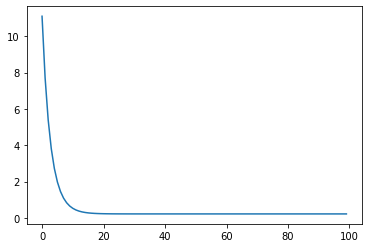

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(losses)

In [27]:
w

tensor([1.0167, 2.0052, 3.0114], requires_grad=True)

In [23]:
from torch import nn, optim

# Linear 층을 작성. 이번에는 절편은 회귀 계수에 포함하므로 입력 차원을 3으로 하고 bias(절편)을 False로 한다.
net = nn.Linear(in_features=3, out_features=1, bias=False)

# SGD의 최적화기상에서 정의한 네트워크의 파라미터를 전달해서 초기화
optimizer = optim.SGD(net.parameters(), lr=0.1)

# MSE loss 클래스
loss_fn = nn.MSELoss()

In [24]:
losses = []

for epoc in range(100):
    # 전회의 backward 메소드로 계산된 경사값을 초기화
    optimizer.zero_grad()
    
    # 선형 모델으로 y예측값을 계산
    y_pred = net(x)
    
    # MSE loss 계산
    # y_pred는 (n,1)과 같은 shape를 지니고 있으므로 (n,)으로 변경할 필요가 있다.
    loss = loss_fn(y_pred.view_as(y), y)
    
    # loss의 w를 사용한 미분 게산
    loss.backward()
    # 경사를 갱신한다
    optimizer.step()
    # 수렴 확인을 위한 loss를 기록해 둔다
    losses.append(loss.item())
    

In [25]:
list(net.parameters())

[Parameter containing:
 tensor([[1.0167, 2.0052, 3.0114]], requires_grad=True)]

# 2.4 로지스틱 회귀(Logistic Regression)
## 2.4.1 로지스틱 회귀의 최대 우도 추정

[0,1] 사이의 값을 얻기 위해 sigmoid 함수를 적용해야한다
이 모델에서는 y가 파라미터 z의 베르누이 분포를 따른다고 가정한다.
베르누이 분포의 우도식을 적용하면 크로스 엔트로피 라는 양이 된다.

In [61]:
# iris 데이터 준비
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
iris = load_iris()

# iris는 (0,1,2)의 세 가지 종류를 분류하는 문제 이므로 (0,1)의 두 개 데이터만 사용한다.
# 원래는 학습용과 테스트용으로 나누어야 하지만 여기선 생략

x = iris.data[:100]
y = iris.target[:100]

# NumPy의 ndarray를 PyTorch의 Tensor로 변환
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [62]:
# iris 데이터는 4차원
net = nn.Linear(4,1)

# 시그모이드 함수를 적용해서 두 클래스의 분류를 위한 크로스 엔트로피를 계산
loss_fn = nn.BCEWithLogitsLoss()

# SGD(약간 큰 학습률)
optimizer = optim.SGD(net.parameters(), lr=0.25)


In [63]:
# 손실 함수 로그
losses = []

# 100회 반복
for epoc in range(1000):
    # 경사값 초기화
    optimizer.zero_grad()
    
    y_pred = net(x)
    
    # MSE loss를 사용한 미분 계산
    loss = loss_fn(y_pred.view_as(y),y)
    loss.backward()
    
    # 경사를 갱신
    optimizer.step()
    
    # 수렴 확인을 위한 loss를 기록해 둔다
    losses.append(loss.item())

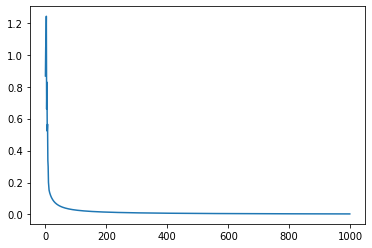

In [64]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(losses)

In [65]:
# 선형 결합의 결과
h = net(x)

# sigmoid 함수를 적용한 결고하는 y=1의 확률을 보여준다.
prob = nn.functional.sigmoid(h)
# 확률이 0.5 이상인 것을 클래스 1로 예측하고 그 외는 0으로 한다. PyTorch에는 Bool형이 없으므로 ByteTensor가 출력
y_pred = prob > 0.5

(y.byte() == y_pred.view_as(y).sum().item())

C:\Users\ICSP\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

# 2.4.3 다중 분류를 위한 로지스틱 회귀 분석
로지스틱 회귀는 두가지 뿐만이 아니라 여러가지를 분류할 수 있다.
선형 결합 게층의 출력을 1차원이 아닌 분류의 차원으로 만들고 손실 함수를 소프트맥스 크로스 엔트로피라는 함수로 변경하면 된다.

In [83]:
# 손으로 쓴 10개의 숫자 데이터를 분류하는 문제
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
digits = load_digits()

x = digits.data
y = digits.target

x = torch.tensor(x, dtype = torch.float32)
# Cross Entropy Loss 함수는 y로 int64형의 텐서를 받으니 주의!
y = torch.tensor(y, dtype = torch.int64)

net = nn.Linear(x.size()[1], 10)

# 소프트맥스 크로스 엔트로피
loss_fn = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr = 0.01)

In [84]:
# 학습용 반복 처리
losses = []

for epoc in range(100):
    optimizer.zero_grad()
    # 선형 모델로 y 예측 값
    y_pred = net(x)
    
    loss = loss_fn(y_pred, y)
    loss.backward()
    
    optimizer.step()
    
    losses.append(loss.item())

In [85]:
# 정답률

# torch.max는 집계축을 지정하면 최댓값뿐만 아니라 그 위치도 반환한다
_, y_pred = torch.max(net(x), 1)
# 정답률 계산
(y_pred == y).sum().item() / len(y)

0.9515859766277128